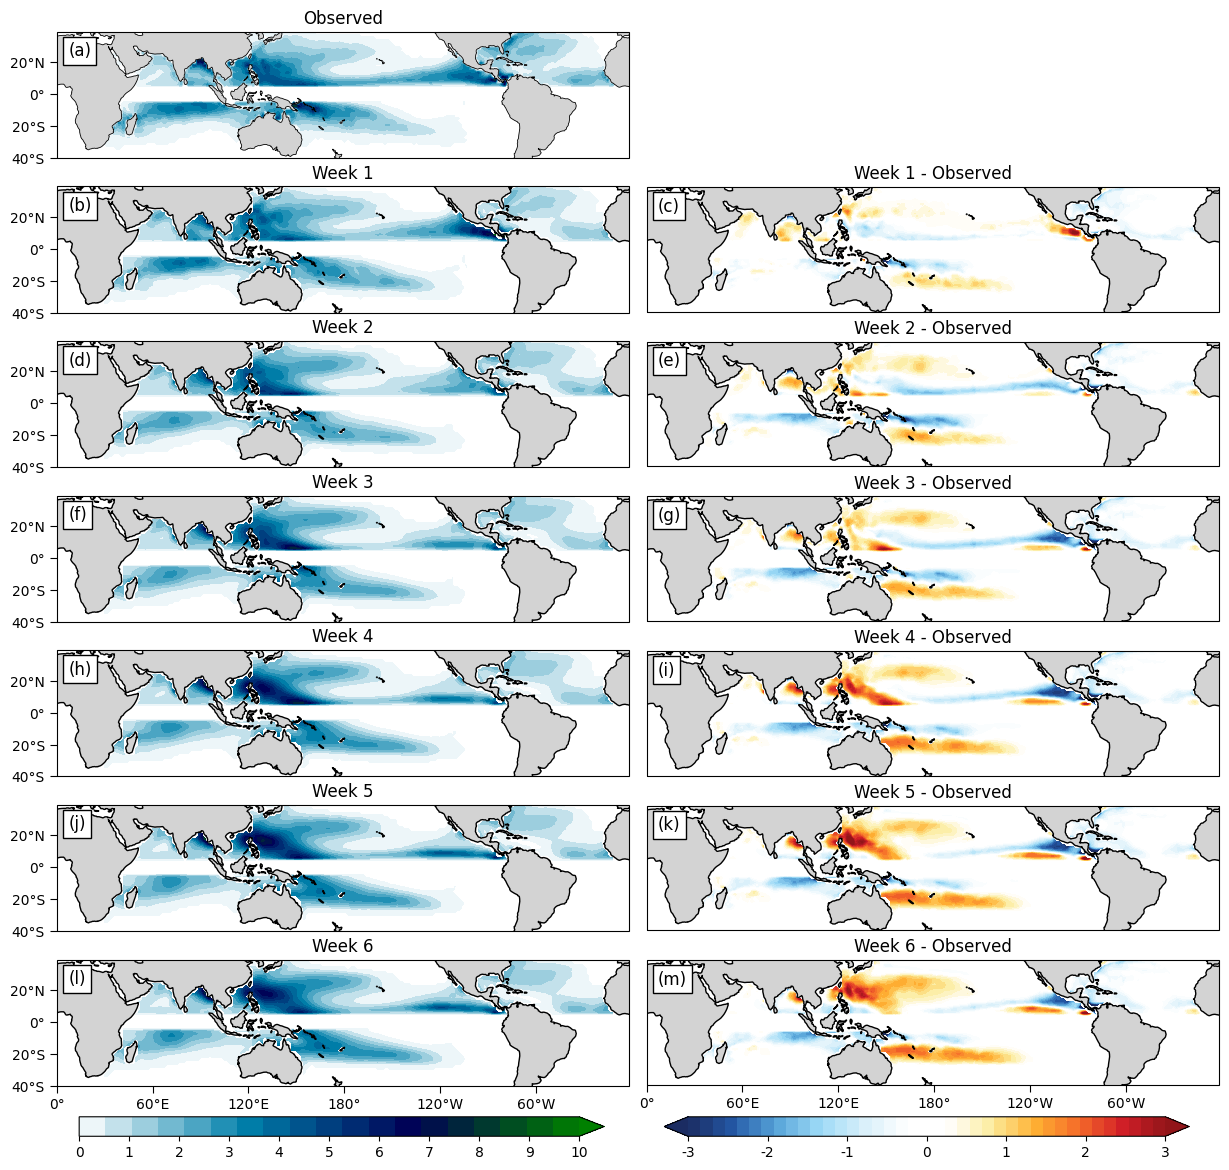

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import num2date
import matplotlib.path as mpath
import cmaps

def process_dataset(filepath, selected_months, polygons=None):
    dataset = nc.Dataset(filepath)
    
    omega = dataset.variables['dgpi'][:]  
    lat = dataset.variables['lat'][:]  
    lon = dataset.variables['lon'][:]  
    time = dataset.variables['time'][:]  
    time_units = dataset.variables['time'].units
    calendar = dataset.variables['time'].calendar if 'calendar' in dataset.variables['time'].ncattrs() else 'gregorian'

    dates = num2date(time, units=time_units, calendar=calendar)
    months = np.array([d.month for d in dates])

    month_indices = np.where(np.isin(months, selected_months))[0]

    omega_subset = omega[month_indices, :, :]

    lat_min, lat_max = -40, 40
    lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    lat_subset = lat[lat_indices]
    lon_subset = lon

    omega_filtered = omega_subset[:, lat_indices, :]
    mean_omega = np.mean(omega_filtered, axis=0)

    lon_subset = np.where(lon_subset < 0, lon_subset + 360, lon_subset)

    lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)

    if polygons:
        mask = np.zeros(lon_grid.shape, dtype=bool)
        for polygon in polygons:
            path = mpath.Path(polygon)
            for i in range(lon_grid.shape[0]):
                for j in range(lon_grid.shape[1]):
                    if path.contains_point((lon_grid[i, j], lat_grid[i, j])):
                        mask[i, j] = True
        mean_omega[~mask] = np.nan  

    return lon_grid, lat_grid, mean_omega

polygon_coordsi = np.array([[30, 0], [100, 0], [100, 31], [30, 31], [30, 0]])
polygon_coords = np.array([[100, 0], [180, 0], [180, 40], [100, 40], [100, 0]])
polygon_coords1 = np.array([[180, 0], [290, 0], [260, 20], [260, 40], [180, 40], [180, 0]])
polygon_coords2 = np.array([[290, 0], [260, 20], [260, 40], [360, 40], [360, 0], [290, 0]])
polygon_coordsh = np.array([[30, 0], [30, -40], [258, -40], [256, 0]])

polygons = [polygon_coordsi,polygon_coords, polygon_coords1, polygon_coords2, polygon_coordsh]

filepaths = [
    'Data_TC/Spatial/large_scale/dgpi_obs_clim.nc',
    'Data_TC/Spatial/large_scale/week1/dgpi.nc',
    'Data_TC/Spatial/large_scale/week2/dgpi.nc',
    'Data_TC/Spatial/large_scale/week3/dgpi.nc',
    'Data_TC/Spatial/large_scale/week4/dgpi.nc',
    'Data_TC/Spatial/large_scale/week5/dgpi.nc',
    'Data_TC/Spatial/large_scale/week6/dgpi.nc'
]

selected_months = np.array([1,2,3,4,5, 6, 7, 8, 9, 10, 11,12])  

observed_filepath = filepaths[0]
lon_grid, lat_grid, observed_omega = process_dataset(observed_filepath, selected_months, polygons)

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

axes = axes.flatten()

vmin, vmax = 0, 10
diff_vmin, diff_vmax = -3, 3

ax_observed = axes[0]
ax_observed.add_feature(cfeature.LAND, edgecolor='k', linewidth=0.6,facecolor='lightgray', zorder=2)
ax_observed.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

c = ax_observed.contourf(lon_grid, lat_grid, observed_omega, cmap='ocean_r', levels=np.linspace(vmin, vmax, 20),
                         vmin=vmin, vmax=vmax, extend='max', transform=ccrs.PlateCarree())
ax_observed.set_title('Observed')

axes[1].set_visible(False)

for i, filepath in enumerate(filepaths[1:]):
    # Process weekly data
    _, _, weekly_omega = process_dataset(filepath, selected_months, polygons)
    
    ax = axes[(i + 1) * 2]
    ax.add_feature(cfeature.LAND, edgecolor='k', linewidth=1, facecolor='lightgray', zorder=2,)
    ax.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

    ax.contourf(lon_grid, lat_grid, weekly_omega, cmap='ocean_r', levels=np.linspace(vmin, vmax, 20),
                vmin=vmin, vmax=vmax, extend='max', transform=ccrs.PlateCarree())

    ax.set_title(f'Week {i+1}')

    ax_diff = axes[(i + 1) * 2 + 1]
    difference = weekly_omega - observed_omega
    
    ax_diff.add_feature(cfeature.LAND, edgecolor='k',linewidth=1, facecolor='lightgray', zorder=2)
    #ax_diff.add_feature(cfeature.COASTLINE)
    ax_diff.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

    k = ax_diff.contourf(lon_grid, lat_grid, difference, cmap=cmaps.BlueWhiteOrangeRed, levels=np.linspace(diff_vmin, diff_vmax, 40),
                         vmin=diff_vmin, vmax=diff_vmax, extend='both', transform=ccrs.PlateCarree())

    ax_diff.set_title(f'Week {i+1} - Observed')

for i, ax in enumerate(axes):  
    if ax.get_visible(): 
        if i % 2 == 0: 
            ax.set_yticks(np.arange(-40, 40, 20), crs=ccrs.PlateCarree())
            lat_ticks = [-40, -20, 0, 20]  
            lat_labels = ['40°S', '20°S', '0°', '20°N']
            ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
            ax.set_yticklabels(lat_labels, fontsize=10)
        else:  
            ax.yaxis.set_visible(False)
        
        if i >= len(axes) - 2: 
            ax.set_xticks(np.arange(0, 361, 40), crs=ccrs.PlateCarree())
            lon_ticks = [0, 60, 120, 180, 240, 300]  
            lon_labels = ['0°', '60°E', '120°E', '180°', '120°W', '60°W']

            ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
            ax.set_xticklabels(lon_labels, fontsize=10, color='white')
        else: 
            ax.set_xticks([])  

        ax.tick_params(axis='both', colors='k', size=5)

        gl = ax.gridlines(draw_labels=False, color='none', linestyle='--', linewidth=0.000001)
        gl.xlocator = plt.FixedLocator(np.arange(0, 361, 40))
        gl.ylocator = plt.FixedLocator(np.arange(-40, 40, 20))
    
        labels = ['(a)', 'b','(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)', '(m)', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
        if i < len(labels):
            label = labels[i]
        else:
            label = chr(97 + i)  
        ax.text(
    0.02, 0.92, label, 
    transform=ax.transAxes, 
    fontsize=12, 
    va='top', 
    ha='left', 
    color='k',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.3')  
)     

cbar_ax1 = fig.add_axes([0.14, 0.11, 0.35, 0.013])  
cbar1 = fig.colorbar(c, cax=cbar_ax1, orientation='horizontal', pad=0.1)
cbar1.set_ticks(np.linspace(vmin, vmax, 11))  
cbar1.set_ticklabels([str(int(tick)) for tick in np.linspace(vmin, vmax, 11)])

cbar_ax2 = fig.add_axes([0.53, 0.11, 0.35, 0.013])  
cbar2 = fig.colorbar(k, cax=cbar_ax2, orientation='horizontal', pad=0.1)
cbar2.set_ticks(np.linspace(diff_vmin, diff_vmax, 7)) 
cbar2.set_ticklabels([str(int(tick)) for tick in np.linspace(diff_vmin, diff_vmax, 7)])

plt.subplots_adjust(hspace=-0.32, wspace=0.03)
#plt.savefig('Figures/Figure16.png', dpi=400, bbox_inches='tight')
plt.show()


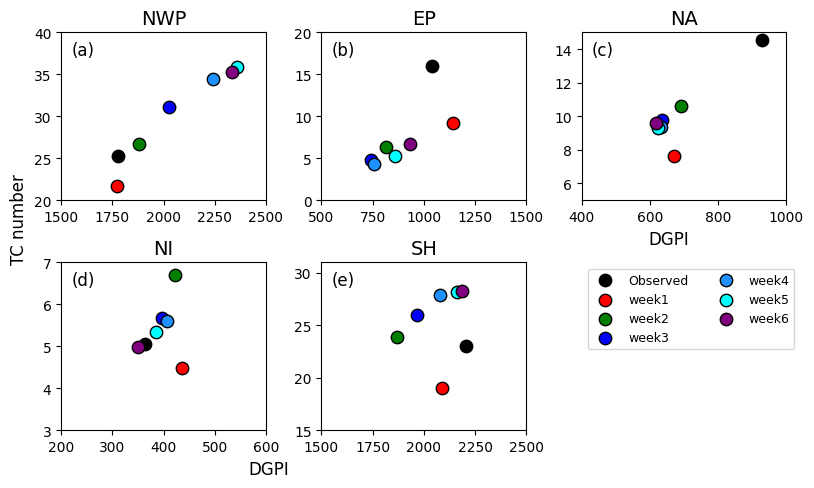

In [2]:
import matplotlib.pyplot as plt

# Data from the image
weeks = ['Observed', 'week1', 'week2', 'week3', 'week4', 'week5', 'week6']
GPI_dict = {
    'WP_GPI': [1779.54, 1771.59, 1882.12, 2026.77, 2239.00, 2357.14, 2335.16],
    'EP_GPI': [1040.49, 1144.31, 814.23, 742.34, 757.16, 861.02, 934.32],
    'NA_b_GPI': [929.77, 671.24, 690.98, 635.98, 632.51, 624.62, 618.89],
    'NI_GPI': [364.09, 436.51, 422.16, 396.50, 406.91, 384.74, 350.35],
    'SH_GPI': [2206.11, 2089.90, 1866.85, 1965.56, 2079.81, 2163.52, 2184.19]
}
TC_dict = {
    'WP_TC': [25.31579, 21.69375, 26.67188, 31.05625, 34.48125, 35.825, 35.22813],
    'EP_TC': [16.05, 9.171875, 6.38125, 4.7875, 4.309375, 5.321875, 6.734375],
    'NA_TC': [14.55, 7.65, 10.60625, 9.775, 9.384375, 9.28125, 9.584375],
    'NI_TC': [5.05, 4.475, 6.7, 5.6625, 5.6125, 5.3375, 4.98125],
    'SH_TC': [23.05, 18.98125, 23.915625, 26.009375, 27.86875, 28.140625, 28.303125]
}

# Define axis ranges for each subplot
x_ranges = {
    'WP_GPI': (1500, 2500),
    'EP_GPI': (500, 1500),
    'NA_b_GPI': (400, 1000),
    'NI_GPI': (200, 600),
    'SH_GPI': (1500, 2500)
}

y_ranges = {
    'WP_TC': (20, 40),
    'EP_TC': (0, 20),
    'NA_TC': (5, 15),
    'NI_TC': (3, 7),
    'SH_TC': (15, 31)
}

fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=False)
axs = axs.flatten()

colors = ['black', 'red', 'green', 'blue', 'dodgerblue', 'cyan', 'purple']
markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o']
sizes = [80, 80, 80, 80, 80, 80, 80]  

for i, (gpi_key, tc_key) in enumerate(zip(GPI_dict.keys(), TC_dict.keys())):
    for j, (week, marker) in enumerate(zip(weeks, markers)):
        axs[i].scatter(GPI_dict[gpi_key][j], TC_dict[tc_key][j], 
                       color=colors[j], marker=marker, s=sizes[j],
                       edgecolor='black', label=week if i == 0 else "")
    
    axs[i].set_xlim(x_ranges[gpi_key])
    axs[i].set_ylim(y_ranges[tc_key])

    axs[i].text(0.05, 0.95, f'({chr(97 + i)})', transform=axs[i].transAxes, fontsize=12, verticalalignment='top')
    
    # Set subplot titles
    basin_titles = ['NWP', 'EP', 'NA', 'NI', 'SH']
    axs[i].set_title(basin_titles[i], fontsize=14)

legend_axes = fig.add_subplot(2, 3, 6)  
legend_axes.axis('off')  

handles, labels = axs[0].get_legend_handles_labels()  
legend_axes.legend(handles, labels, loc='upper left', ncol=len(weeks), ncols=2, fontsize=9)
fig.delaxes(axs[5])
fig.text(0.00, 0.5, 'TC number', ha='center', va='center', rotation='vertical', fontsize=12)
fig.text(0.25, 0.0, 'DGPI', ha='center', va='center', rotation='horizontal', fontsize=12)
fig.text(0.65, 0.46, 'DGPI', ha='center', va='center', rotation='horizontal', fontsize=12)

plt.tight_layout(rect=[0, 0, 0.8, 0.95])
plt.savefig('Figures/Figure17.png', dpi=400, bbox_inches='tight')
plt.show()
